In [1]:
import numpy as np
import networkx as nx
import Graph
import Classifier
import argparse
import warnings
import matplotlib.pyplot as plt
from time import perf_counter
from datetime import timedelta
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from multiprocessing import cpu_count

%matplotlib inline

In [2]:
def build_corpus(G, max_paths, path_len, save_walks):
    #Build corpus
    print("\t**Stage 1 : Generating random walks**")
    t1 = perf_counter()
    corpus = Graph.build_walk_corpus(G=G, max_paths=max_paths, path_len=path_len)
    t2 = perf_counter()
    print("\nNumber of walks in the corpus = ",len(corpus))
    print("Time Elapsed for building walk corpus --> ", timedelta(seconds=t2-t1))
    if save_walks:
        Graph.save_corpus(max_paths, path_len, corpus)
    print("---------------------------------------\n")
    return corpus

In [3]:
def load_embeddings(fname):
    try:
        word_vec = KeyedVectors.load_word2vec_format(fname, binary=False)
        print("Embeddings successfully loaded from "+fname)
        return word_vec, True
    except IOError:
        print("Embedding file not found. Proceeding to generate new embeddings")
        # Y/N here
        return _, False

In [4]:
def generate_embeddings(d,w,hs,corpus,save_emb):
    #Train model
    #ToDO: try negative sampling (hs=0)
    print("\t**Stage 2 : Generating Embeddings for nodes using Word2Vec**")
    print("\nWord2Vec parameters : Dimensions = "+str(d)+", window = "+str(w)+", hs = "+str(hs)+", number of cpu cores assigned for training = "+str(cpu_count()))
    
    t1 = perf_counter()
    model = Word2Vec(size = d, window=w, sg=1, min_count=0, hs=hs, workers=cpu_count())
    model.build_vocab(corpus)
    model.train(corpus, total_examples=model.corpus_count, epochs=model.iter)
    t2 = perf_counter()
    
    print("Model training done. Word2Vec embeddings generated.") 
    print("Time Elapsed for generating embeddings --> ", timedelta(seconds=t2-t1))
    
    word_vec = model.wv
    
    if save_emb:
        #Save w2v embeddings
        name = 'word2vec-d'+str(d)+'-w'+str(w)+'-hs'+str(hs)+'.txt'
        word_vec.save_word2vec_format(binary=False,fname=name)
        print("Embeddings saved to file -> ",name)

    print("---------------------------------------\n")
    
    return word_vec

In [5]:
def eval_classifier(G, subs_coo, word_vec):
    #Sometimes the model doesn't predict anything at all for some inputs. Its either the model's fault or that user has no subscriptions at
    #all, in that case the model is predicting properly but of course a zero output would raise exceptions during sklearn's
    #F1 score function.
    #Currently evaluating performance with OVR Logistic Regression.
    print("\t**Stage 3 : Evaluating classifier performance with the embeddings**")

    t1 = perf_counter()
    results = Classifier.evaluate(G, subs_coo, word_vec)
    t2 = perf_counter()

    print("\n Evaluation completed using the following:")
    for i in results.keys():
        print("--> ",i)
    print("Time Elapsed for evaluation --> ", timedelta(seconds=t2-t1))
    print("---------------------------------------\n")

    print("Printing evaluation results : ")
    trainsize = [0.2, 0.5, 0.8, 0.9]
    for (name,res) in results.items():
        print("\n\nClassifier : ",name)
        for (tr_size,res_) in zip(trainsize,res):
            print("\tTraining size : ",tr_size)
            print("\t\tMicro F1: ",res_[0])
            print("\t\tMacro F1: ",res_[1])
        
        avg = np.average(res,axis=0)
        print("\t---------------------------------------")
        print("\t Average Micro F1 : ",avg[0])
        print("\t Average Macro F1 : ",avg[1])
        Classifier.plot_graph(trainsize, res)
        print("====================================================\n")


In [6]:
def process(args):

    dimensions = args.d
    max_paths = args.walks
    path_len = args.len
    window = args.window
    hs = args.hs
    save_walks = args.w
    save_emb = args.e
    load_corpus = args.lw
    load_emb = args.le
    readCorpusFlag = False
    readEmbedFlag = False
    
    #Open and parse dataset
    G, subs_coo = Graph.parse_mat_file('blogcatalog.mat')

    if load_emb:
        word_vec, readEmbedFlag = load_embeddings(load_emb)

        #if there's error in reading the specified embedding file, build corpus and generate embeddings
        #unless interrupted by user
        if readEmbedFlag == False:
            #Build Corpus 
            corpus = build_corpus(G, max_paths=args.walks, path_len=args.len, save_walks=args.w)
            #Train word2vec model and generate embeddings
            word_vec = generate_embeddings(dimensions, window, hs, corpus, save_emb)

    #If no embedding file is given
    else:    
        #If corpus file is specified
        if load_corpus:
                corpus, max_paths, path_len, readCorpusFlag = Graph.load_corpus(G,load_corpus)

        #If corpus file is not specified or if loading the file fails
        if readCorpusFlag == False:
                corpus = build_corpus(G, max_paths=args.walks, path_len=args.len, save_walks=args.w)
        
        #Generate new Embeddings
        word_vec = generate_embeddings(dimensions, window, hs, corpus, save_emb)

    #Evaluate the embeddings by passing it through classifier(s)
    eval_classifier(G, subs_coo, word_vec)


In [7]:
def main():

    parser = argparse.ArgumentParser("DeepWalk", description = "Implementation of "+ 
        "DeepWalk model. File Author: Apoorva")
    parser.add_argument("--d", default=128, type=int, help="Dimensions of word embeddings")
    parser.add_argument("--walks", default=10, type=int, help="Number of walks per node")
    parser.add_argument("--len", default=30, type=int, help="Length of random walk")
    parser.add_argument("--window", default=5, type=int, help="Window size for skipgram")
    parser.add_argument("--hs", default=1, type=int, help="0 - Negative Sampling  1 - Hierarchical Softmax")
    parser.add_argument("--lw", default='', help="Load random walk corpus from file")
    parser.add_argument("--le", default='', help="Load embeddings from file")
    parser.add_argument("-w", action='store_true', help="Flag to save random walk corpus to disk")
    parser.add_argument("-e", action='store_true', help='Flag to save word embeddings to disk')
    warnings.filterwarnings("ignore")
    
    #Enter cmd line arguments here. Leave it blank if you want default parameters.
    #Eg : "--d 64 -w -e"
    # "--d 128 --walks 40 --len 80 --window 10 -w -e"
    cmdargs = "--d 128 --window 10 --lw RandomWalks-w40-l80.txt -e"
    args = parser.parse_args(cmdargs.split())
    
    process(args)
   

Name: blogcatalog.mat
Type: Graph
Number of nodes: 10312
Number of edges: 333983
Average degree:  64.7756
---------------------------------------

Successfully loaded corpus from file  RandomWalks-w40-l80.txt
	**Stage 2 : Generating Embeddings for nodes using Word2Vec**

Word2Vec parameters : Dimensions = 128, window = 10, hs = 1, number of cpu cores assigned for training = 40
Model training done. Word2Vec embeddings generated.
Time Elapsed for generating embeddings -->  0:15:57.589581
Embeddings saved to file ->  word2vec-d128-w10-hs1.txt
---------------------------------------

	**Stage 3 : Evaluating classifier performance with the embeddings**

 Evaluation completed using the following:
-->  Logistic_Regression
Time Elapsed for evaluation -->  0:00:11.265216
---------------------------------------

Printing evaluation results : 


Classifier :  Logistic_Regression
	Training size :  0.2
		Micro F1:  0.3838776568170037
		Macro F1:  0.23592615934605854
	Training size :  0.5
		Micro F1

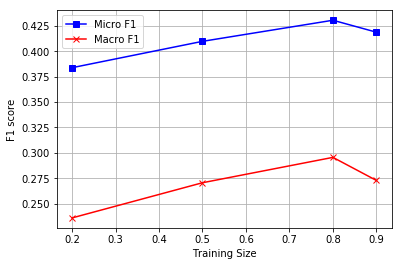

In [8]:
if __name__ == "__main__":
    main()